# NoETL Playbook Execution Report
__Agent 007 mission report:__ _Operation completed. Martini status: shaken, not stirred._
- This notebook provides a report of the execution of a NoETL playbook using the `agent007.py` script.
- It analyzes the DuckDB database generated during the playbook run, with execution flow, step results, loop iterations, task executions, and context data captured throughout the process.
1. Run playbook with `agent007.py`.
2. Set `db_path` below to that file path.
3. Run all paragraphs to inspect tables and data.


## Set the database path and list all tables


In [147]:
import duckdb
import polars as pl
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import networkx as nx
from datetime import datetime

# Path to DuckDB database
db_path = '../data/noetldb/agent007.duckdb'  # Default path used by agent007.py
# Example: db_path = '/Users/kadyapam/projects/noetl/noetl/noetl/runtime/agent007.duckdb'

if not os.path.exists(db_path) and db_path != ':memory:':
    raise FileNotFoundError(f"DuckDB database not found: {db_path}")

con = duckdb.connect(db_path)

def parse_json_column(df, column_name):
    if column_name in df.columns:
        def safe_json_parse(x):
            if not x:
                return None
            try:
                return json.loads(x)
            except json.JSONDecodeError as e:
                print(f"Warning: Could not parse JSON: {e}")
                return x

        return df.with_columns([
            pl.col(column_name).map_elements(safe_json_parse, return_dtype=pl.Object)
        ])
    return df

latest_execution = con.execute("""
    SELECT execution_id, MAX(timestamp) as latest_time
    FROM event_log
    GROUP BY execution_id
    ORDER BY latest_time DESC
    LIMIT 1
""").fetchone()

if latest_execution:
    execution_id = latest_execution[0]
    print(f"Analyzing execution ID: {execution_id}")
else:
    print("No executions found in the database.")
    execution_id = None


Analyzing execution ID: b20125a1-1eed-4015-a4ee-e6ea556c1f4b


In [123]:
tables = con.execute("SHOW TABLES").fetchall()
for t in tables:
    print(t[0])


context
event_log
loop_state
step_result
task_result
transition
workbook
workflow


## Execution Overview

Overview of the playbook execution.


In [146]:
if execution_id:
    execution_times = con.execute("""
        SELECT 
            MIN(timestamp) as start_time,
            MAX(timestamp) as end_time,
            (EXTRACT(EPOCH FROM MAX(timestamp)) - EXTRACT(EPOCH FROM MIN(timestamp))) as duration_seconds
        FROM event_log
        WHERE execution_id = ?
    """, [execution_id]).fetchone()

    execution_stats = con.execute("""
        SELECT
            (SELECT COUNT(*) FROM step_result WHERE execution_id = ?) as step_count,
            (SELECT COUNT(*) FROM task_result WHERE execution_id = ?) as task_count,
            (SELECT COUNT(*) FROM loop_state WHERE execution_id = ?) as loop_count,
            (SELECT COUNT(*) FROM event_log WHERE execution_id = ? AND event_type LIKE '%error%') as error_count
    """, [execution_id, execution_id, execution_id, execution_id]).fetchone()

    playbook_info = con.execute("""
        SELECT node_name, metadata
        FROM event_log
        WHERE execution_id = ? AND event_type = 'execution_start'
        LIMIT 1
    """, [execution_id]).fetchone()

    print(f"Playbook: {playbook_info[0] if playbook_info else 'Unknown'}")
    print(f"Start Time: {execution_times[0]}")
    print(f"End Time: {execution_times[1]}")
    print(f"Duration: {execution_times[2]:.2f} seconds")
    print(f"Steps Executed: {execution_stats[0]}")
    print(f"Tasks Executed: {execution_stats[1]}")
    print(f"Loops Executed: {execution_stats[2]}")
    print(f"Errors Encountered: {execution_stats[3]}")

    if playbook_info and playbook_info[1]:
        try:
            metadata = json.loads(playbook_info[1])
            print("\nPlaybook Metadata:")
            for key, value in metadata.items():
                print(f"  {key}: {value}")
        except:
            pass
else:
    print("No execution ID available.")


Playbook: weather_iterator_example
Start Time: 2025-06-16 06:30:01.914083
End Time: 2025-06-16 06:30:04.177720
Duration: 2.26 seconds
Steps Executed: 4
Tasks Executed: 6
Loops Executed: 1
Errors Encountered: 0

Playbook Metadata:
  playbook_path: ./catalog/playbooks/weather_example.yaml


## Step Execution Analysis

Analyze the execution of steps in the playbook.


In [145]:
if execution_id:
    step_results = pl.from_arrow(con.execute("""
        SELECT 
            step_id, 
            step_name, 
            parent_id, 
            timestamp, 
            status, 
            data, 
            error
        FROM step_result
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).arrow())

    step_results = parse_json_column(step_results, 'data')

    step_summary = pl.from_arrow(con.execute("""
        SELECT 
            step_name, 
            COUNT(*) as execution_count,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as success_count,
            COUNT(CASE WHEN status = 'error' THEN 1 END) as error_count
        FROM step_result
        WHERE execution_id = ?
        GROUP BY step_name
        ORDER BY execution_count DESC
    """, [execution_id]).arrow())

    print("Step Execution Summary:")
    display(step_summary)
    print("\nStep Results:")
    display(step_results)
else:
    print("No execution ID available.")


Step Execution Summary:


step_name,execution_count,success_count,error_count
str,i64,i64,i64
"""city_loop""",1,1,0
"""end_city_loop""",1,1,0
"""start""",1,1,0
"""aggregate_alerts""",1,1,0



Step Results:


shape: (4, 7)
┌────────────────┬───────────────┬───────────────┬───────────────┬─────────┬───────────────┬───────┐
│ step_id        ┆ step_name     ┆ parent_id     ┆ timestamp     ┆ status  ┆ data          ┆ error │
│ ---            ┆ ---           ┆ ---           ┆ ---           ┆ ---     ┆ ---           ┆ ---   │
│ str            ┆ str           ┆ str           ┆ datetime[μs]  ┆ str     ┆ object        ┆ str   │
╞════════════════╪═══════════════╪═══════════════╪═══════════════╪═════════╪═══════════════╪═══════╡
│ 9d185ce7-f540- ┆ start         ┆ null          ┆ 2025-06-16    ┆ success ┆ {}            ┆ null  │
│ 47ff-b779-0779 ┆               ┆               ┆ 06:30:01.9155 ┆         ┆               ┆       │
│ 7b…            ┆               ┆               ┆ 30            ┆         ┆               ┆       │
│ 7cdac2c8-c330- ┆ city_loop     ┆ null          ┆ 2025-06-16    ┆ success ┆ [{'fetch_and_ ┆ null  │
│ 4914-9721-ab2a ┆               ┆               ┆ 06:30:04.1551 ┆         ┆ evaluate':    ┆       │
│ d5…            ┆               ┆               ┆ 56            ┆         ┆ {'data…       ┆       │
│ ddb4f7b3-ce6e- ┆ end_city_loop ┆ 518ace9b-bf76 ┆ 2025-06-16    ┆ success ┆ {'alerts':    ┆ null  │
│ 4301-9569-88f0 ┆               ┆ -4d89-b915-ab ┆ 06:30:04.1714 ┆         ┆ [{'fetch_and_ ┆       │
│ 60…            ┆               ┆ 93d5…         ┆ 39            ┆         ┆ evalua…       ┆       │
│ 289243e5-8e42- ┆ aggregate_ale ┆ null          ┆ 2025-06-16    ┆ success ┆ {}            ┆ null  │
│ 4eb6-ac2a-a7c7 ┆ rts           ┆               ┆ 06:30:04.1756 ┆         ┆               ┆       │
│ 26…            ┆               ┆               ┆ 55            ┆         ┆               ┆       │
└────────────────┴───────────────┴───────────────┴───────────────┴─────────┴───────────────┴───────┘

## Loop Execution Analysis

Analyze the execution of loops in the playbook.


In [144]:
if execution_id:
    loop_state = pl.from_arrow(con.execute("""
        SELECT 
            loop_id, 
            loop_name, 
            parent_id, 
            iterator, 
            items, 
            current_index, 
            current_item, 
            results, 
            timestamp, 
            status
        FROM loop_state
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).arrow())

    loop_state = parse_json_column(loop_state, 'items')
    loop_state = parse_json_column(loop_state, 'current_item')
    loop_state = parse_json_column(loop_state, 'results')

    if len(loop_state) > 0:
        print("Loop Execution Summary:")
        display(loop_state)

        loop_events = pl.from_arrow(con.execute("""
            SELECT 
                event_id, 
                node_name, 
                event_type, 
                timestamp, 
                status, 
                duration, 
                output_result as data, 
                metadata
            FROM event_log
            WHERE execution_id = ? AND event_type LIKE '%loop%'
            ORDER BY timestamp
        """, [execution_id]).arrow())

        loop_events = parse_json_column(loop_events, 'data')
        loop_events = parse_json_column(loop_events, 'metadata')

        print("\nLoop Events:")
        display(loop_events)
    else:
        print("No loop executions found.")
else:
    print("No execution ID available.")


Loop Execution Summary:


shape: (1, 10)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ loop_id   ┆ loop_name ┆ parent_id ┆ iterator ┆ … ┆ current_i ┆ results   ┆ timestamp ┆ status    │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ tem       ┆ ---       ┆ ---       ┆ ---       │
│ str       ┆ str       ┆ str       ┆ str      ┆   ┆ ---       ┆ object    ┆ datetime[ ┆ str       │
│           ┆           ┆           ┆          ┆   ┆ object    ┆           ┆ μs]       ┆           │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 518ace9b- ┆ city_loop ┆ 7cdac2c8- ┆ city     ┆ … ┆ null      ┆ [{'fetch_ ┆ 2025-06-1 ┆ completed │
│ bf76-4d89 ┆           ┆ c330-4914 ┆          ┆   ┆           ┆ and_evalu ┆ 6 06:30:0 ┆           │
│ -b915-ab9 ┆           ┆ -9721-ab2 ┆          ┆   ┆           ┆ ate':     ┆ 4.170932  ┆           │
│ 3d5…      ┆           ┆ ad5…      ┆          ┆   ┆           ┆ {'data…   ┆           ┆           │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘


Loop Events:


shape: (10, 8)
┌────────────┬────────────┬────────────┬────────────┬───────────┬──────────┬───────────┬───────────┐
│ event_id   ┆ node_name  ┆ event_type ┆ timestamp  ┆ status    ┆ duration ┆ data      ┆ metadata  │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       ┆ ---      ┆ ---       ┆ ---       │
│ str        ┆ str        ┆ str        ┆ datetime[μ ┆ str       ┆ f64      ┆ object    ┆ object    │
│            ┆            ┆            ┆ s]         ┆           ┆          ┆           ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══════════╪══════════╪═══════════╪═══════════╡
│ 49359fcc-5 ┆ city_loop  ┆ loop_start ┆ 2025-06-16 ┆ in_progre ┆ 0.0      ┆ null      ┆ {'item_co │
│ 739-4173-a ┆            ┆            ┆ 06:30:01.9 ┆ ss        ┆          ┆           ┆ unt': 3,  │
│ 628-db8e3d ┆            ┆            ┆ 19944      ┆           ┆          ┆           ┆ 'iterator │
│ …          ┆            ┆            ┆            ┆           ┆          ┆           ┆ ': …      │
│ 56637617-5 ┆ city_loop[ ┆ loop_itera ┆ 2025-06-16 ┆ in_progre ┆ 0.0      ┆ null      ┆ {'index': │
│ e0d-4e7c-8 ┆ 0]         ┆ tion       ┆ 06:30:01.9 ┆ ss        ┆          ┆           ┆ 0,        │
│ 4e4-31b543 ┆            ┆            ┆ 24356      ┆           ┆          ┆           ┆ 'item':   │
│ …          ┆            ┆            ┆            ┆           ┆          ┆           ┆ {'name':  │
│            ┆            ┆            ┆            ┆           ┆          ┆           ┆ …         │
│ f759d171-5 ┆ city_loop[ ┆ loop_itera ┆ 2025-06-16 ┆ success   ┆ 0.0      ┆ {'fetch_a ┆ {'index': │
│ 762-479c-9 ┆ 0]         ┆ tion_compl ┆ 06:30:02.7 ┆           ┆          ┆ nd_evalua ┆ 0,        │
│ 9fc-e0402a ┆            ┆ ete        ┆ 52001      ┆           ┆          ┆ te':      ┆ 'item':   │
│ …          ┆            ┆            ┆            ┆           ┆          ┆ {'data'…  ┆ {'name':  │
│            ┆            ┆            ┆            ┆           ┆          ┆           ┆ …         │
│ 2bde7481-f ┆ city_loop[ ┆ loop_itera ┆ 2025-06-16 ┆ in_progre ┆ 0.0      ┆ null      ┆ {'index': │
│ f84-4ea3-8 ┆ 1]         ┆ tion       ┆ 06:30:02.7 ┆ ss        ┆          ┆           ┆ 1,        │
│ bd0-d067ad ┆            ┆            ┆ 52926      ┆           ┆          ┆           ┆ 'item':   │
│ …          ┆            ┆            ┆            ┆           ┆          ┆           ┆ {'name':  │
│            ┆            ┆            ┆            ┆           ┆          ┆           ┆ …         │
│ f918afd5-b ┆ city_loop[ ┆ loop_itera ┆ 2025-06-16 ┆ success   ┆ 0.0      ┆ {'fetch_a ┆ {'index': │
│ 79d-42fa-b ┆ 1]         ┆ tion_compl ┆ 06:30:03.4 ┆           ┆          ┆ nd_evalua ┆ 1,        │
│ 219-8b6b02 ┆            ┆ ete        ┆ 45477      ┆           ┆          ┆ te':      ┆ 'item':   │
│ …          ┆            ┆            ┆            ┆           ┆          ┆ {'data'…  ┆ {'name':  │
│            ┆            ┆            ┆            ┆           ┆          ┆           ┆ …         │
│ 5faa0d94-b ┆ city_loop[ ┆ loop_itera ┆ 2025-06-16 ┆ in_progre ┆ 0.0      ┆ null      ┆ {'index': │
│ 892-4ad8-a ┆ 2]         ┆ tion       ┆ 06:30:03.4 ┆ ss        ┆          ┆           ┆ 2,        │
│ caf-dff993 ┆            ┆            ┆ 46417      ┆           ┆          ┆           ┆ 'item':   │
│ …          ┆            ┆            ┆            ┆           ┆          ┆           ┆ {'name':  │
│            ┆            ┆            ┆            ┆           ┆          ┆           ┆ …         │
│ 9d336b6c-2 ┆ city_loop[ ┆ loop_itera ┆ 2025-06-16 ┆ success   ┆ 0.0      ┆ {'fetch_a ┆ {'index': │
│ 156-4c4c-b ┆ 2]         ┆ tion_compl ┆ 06:30:04.1 ┆           ┆          ┆ nd_evalua ┆ 2,        │
│ 869-6b44ba ┆            ┆ ete        ┆ 53874      ┆           ┆          ┆ te':      ┆ 'item':   │
│ …          ┆            ┆            ┆            ┆           ┆          ┆ {'data'…  ┆ {'name':  │
│            ┆            ┆            ┆      

## Task Execution Analysis

Analyze the execution of tasks in the playbook.


In [143]:
if execution_id:
    task_results = pl.from_arrow(con.execute("""
        SELECT 
            task_id, 
            task_name, 
            task_type, 
            parent_id, 
            timestamp, 
            status, 
            data, 
            error
        FROM task_result
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).arrow())

    task_results = parse_json_column(task_results, 'data')

    task_summary = pl.from_arrow(con.execute("""
        SELECT 
            task_name, 
            task_type,
            COUNT(*) as execution_count,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as success_count,
            COUNT(CASE WHEN status = 'error' THEN 1 END) as error_count
        FROM task_result
        WHERE execution_id = ?
        GROUP BY task_name, task_type
        ORDER BY execution_count DESC
    """, [execution_id]).arrow())

    print("Task Execution Summary:")
    display(task_summary)
    print("\nTask Results:")
    display(task_results)
else:
    print("No execution ID available.")


Task Execution Summary:


task_name,task_type,execution_count,success_count,error_count
str,str,i64,i64,i64
"""get_forecast""","""http""",3,3,0
"""evaluate_weather""","""python""",3,3,0



Task Results:


task_id,task_name,task_type,parent_id,timestamp,status,data,error
str,str,str,str,datetime[μs],str,object,str
"""7d4f7d81-8901-4f6b-a221-e5f794…","""get_forecast""","""http""","""9a0a3928-3095-40d0-80cd-2ca6bc…",2025-06-16 06:30:02.729848,"""success""","{'data': {'latitude': 51.5, 'longitude': -0.120000124, 'generationtime_ms': 0.06711483001708984, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 29.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-06-16T02:00', '2025-06-16T03:00', '2025-06-16T04:00', '2025-06-16T05:00', '2025-06-16T06:00', '2025-06-16T07:00', '2025-06-16T08:00', '2025-06-16T09:00', '2025-06-16T10:00', '2025-06-16T11:00', '2025-06-16T12:00', '2025-06-16T13:00', '2025-06-16T14:00', '2025-06-16T15:00', '2025-06-16T16:00', '2025-06-16T17:00', '2025-06-16T18:00', '2025-06-16T19:00', '2025-06-16T20:00', '2025-06-16T21:00', '2025-06-16T22:00', '2025-06-16T23:00'], 'temperature_2m': [17.1, 16.5, 16.1, 15.5, 15.1, 14.9, 15.5, 16.5, 17.9, 19.4, 20.6, 21.7, 22.8, 23.5, 24.2, 24.8, 25.3, 25.1, 25.3, 23.1, 22.0, 20.8, 19.9, 19.1]}}, 'status_code': 200, 'headers': {'date': 'Mon, 16 Jun 2025 13:30:02 GMT', 'content-type': 'application/json; charset=utf-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'content-encoding': 'deflate'}}",null
"""b9a82f30-87e3-470c-9e51-73686d…","""evaluate_weather""","""python""","""89f93495-066c-405c-8e4c-c00f80…",2025-06-16 06:30:02.746455,"""success""","{'city': 'London', 'max_temp': 25.3, 'alert': True}",null
"""21cc73f0-fecc-4694-a7d9-dff2d0…","""get_forecast""","""http""","""ccb48992-b532-457b-8851-d787c4…",2025-06-16 06:30:03.425831,"""success""","{'data': {'latitude': 48.84, 'longitude': 2.3599997, 'generationtime_ms': 0.02944469451904297, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 46.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-06-16T02:00', '2025-06-16T03:00', '2025-06-16T04:00', '2025-06-16T05:00', '2025-06-16T06:00', '2025-06-16T07:00', '2025-06-16T08:00', '2025-06-16T09:00', '2025-06-16T10:00', '2025-06-16T11:00', '2025-06-16T12:00', '2025-06-16T13:00', '2025-06-16T14:00', '2025-06-16T15:00', '2025-06-16T16:00', '2025-06-16T17:00', '2025-06-16T18:00', '2025-06-16T19:00', '2025-06-16T20:00', '2025-06-16T21:00', '2025-06-16T22:00', '2025-06-16T23:00'], 'temperature_2m': [16.3, 15.7, 15.2, 14.5, 14.1, 14.1, 14.8, 15.7, 17.1, 19.4, 21.0, 22.4, 23.8, 25.1, 25.8, 26.0, 26.5, 26.0, 25.6, 25.0, 24.5, 23.5, 22.5, 21.3]}}, 'status_code': 200, 'headers': {'date': 'Mon, 16 Jun 2025 13:30:03 GMT', 'content-type': 'application/json; charset=utf-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'content-encoding': 'deflate'}}",null
"""6b0cb0cf-df1d-439c-b0b8-b00cee…","""evaluate_weather""","""python""","""d21a8b35-8a31-4bae-a5e8-a71cbe…",2025-06-16 06:30:03.440008,"""success""","{'city': 'Paris', 'max_temp': 26.5, 'alert': True}",null
"""96ac962f-9d1d-401d-a44c-5d4be4…","""get_forecast""","""http""","""d127ce2b-e62b-4753-9b85-bf5558…",2025-06-16 06:30:04.130915,"""success""","{'data': {'latitude': 52.52, 'longitude': 13.419998, 'generationtime_ms': 0.021576881408691406, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 38.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-06-16T02:00', '2025-06-16T03:00', '2025-06-16T04:00', '2025-06-16T05:00', '2025-06-16T06:00', '2025-06-16T07:00', '2025-06-16T08:00', '2025-06-16T09:00', '2025-06-16T10:00', '2025-06-16T11:00', '2025-06-16T12:00', '2025-06-16T13:00', '2025-06-16T14:00', '2025-06-16T15:00', '2025-06-16T16:00', '2025-06-16T17:00', '2025-06-16T18:00', '2025-06-16T19:00', '2025-06-16T20:00', '2025-06-16T21:00', '2025-06-16T22:00', '2025-06-16T23:00'], 'tempera

## Context Analysis

Analyze the context data during playbook execution.


In [142]:
if execution_id:
    context_data = pl.from_arrow(con.execute("""
        SELECT 
            key, 
            value, 
            timestamp
        FROM context
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).arrow())

    context_data = parse_json_column(context_data, 'value')

    if len(context_data) > 0:
        print("Context Data:")
        display(context_data)
        final_context = {}
        for _, row in context_data.to_pandas().iterrows():
            final_context[row['key']] = row.get('value')

        print("\nFinal Context State:")
        for key, value in final_context.items():
            print(f"\n{key}:")
            if isinstance(value, (dict, list)):
                print(json.dumps(value, indent=2))
            else:
                print(value)
    else:
        print("No context data found.")
else:
    print("No execution ID found.")


Context Data:


key,value,timestamp
str,object,datetime[μs]
"""workload""","{'jobId': '{{ job.uuid }}', 'state': 'ready', 'cities': [{'name': 'London', 'lat': 51.51, 'lon': -0.13}, {'name': 'Paris', 'lat': 48.85, 'lon': 2.35}, {'name': 'Berlin', 'lat': 52.52, 'lon': 13.41}], 'base_url': 'https://api.open-meteo.com/v1', 'temperature_threshold': 25}",2025-06-16 06:30:01.912784
"""execution_start""",2025-06-16T06:30:01.913746,2025-06-16 06:30:01.913753
"""base_url""",https://api.open-meteo.com/v1,2025-06-16 06:30:03.447483
"""get_forecast""","{'data': {'latitude': 52.52, 'longitude': 13.419998, 'generationtime_ms': 0.021576881408691406, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 38.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-06-16T02:00', '2025-06-16T03:00', '2025-06-16T04:00', '2025-06-16T05:00', '2025-06-16T06:00', '2025-06-16T07:00', '2025-06-16T08:00', '2025-06-16T09:00', '2025-06-16T10:00', '2025-06-16T11:00', '2025-06-16T12:00', '2025-06-16T13:00', '2025-06-16T14:00', '2025-06-16T15:00', '2025-06-16T16:00', '2025-06-16T17:00', '2025-06-16T18:00', '2025-06-16T19:00', '2025-06-16T20:00', '2025-06-16T21:00', '2025-06-16T22:00', '2025-06-16T23:00'], 'temperature_2m': [16.9, 16.9, 16.8, 16.9, 16.7, 16.5, 15.6, 17.2, 18.6, 17.7, 18.0, 19.7, 20.8, 22.3, 22.3, 22.8, 23.1, 22.2, 21.5, 20.5, 19.3, 18.4, 17.6, 16.8]}}, 'status_code': 200, 'headers': {'date': 'Mon, 16 Jun 2025 13:30:04 GMT', 'content-type': 'application/json; charset=utf-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'content-encoding': 'deflate'}}",2025-06-16 06:30:04.135884
"""get_forecast.result""","{'data': {'latitude': 52.52, 'longitude': 13.419998, 'generationtime_ms': 0.021576881408691406, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 38.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-06-16T02:00', '2025-06-16T03:00', '2025-06-16T04:00', '2025-06-16T05:00', '2025-06-16T06:00', '2025-06-16T07:00', '2025-06-16T08:00', '2025-06-16T09:00', '2025-06-16T10:00', '2025-06-16T11:00', '2025-06-16T12:00', '2025-06-16T13:00', '2025-06-16T14:00', '2025-06-16T15:00', '2025-06-16T16:00', '2025-06-16T17:00', '2025-06-16T18:00', '2025-06-16T19:00', '2025-06-16T20:00', '2025-06-16T21:00', '2025-06-16T22:00', '2025-06-16T23:00'], 'temperature_2m': [16.9, 16.9, 16.8, 16.9, 16.7, 16.5, 15.6, 17.2, 18.6, 17.7, 18.0, 19.7, 20.8, 22.3, 22.3, 22.8, 23.1, 22.2, 21.5, 20.5, 19.3, 18.4, 17.6, 16.8]}}, 'status_code': 200, 'headers': {'date': 'Mon, 16 Jun 2025 13:30:04 GMT', 'content-type': 'application/json; charset=utf-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'content-encoding': 'deflate'}}",2025-06-16 06:30:04.136465
…,…,…
"""evaluate_weather.result""","{'city': 'Berlin', 'max_temp': 23.1, 'alert': False}",2025-06-16 06:30:04.151519
"""evaluate_weather.status""",success,2025-06-16 06:30:04.151910
"""result""","{'city': 'Berlin', 'max_temp': 23.1, 'alert': False}",2025-06-16 06:30:04.152177



Final Context State:

workload:
{
  "jobId": "{{ job.uuid }}",
  "state": "ready",
  "cities": [
    {
      "name": "London",
      "lat": 51.51,
      "lon": -0.13
    },
    {
      "name": "Paris",
      "lat": 48.85,
      "lon": 2.35
    },
    {
      "name": "Berlin",
      "lat": 52.52,
      "lon": 13.41
    }
  ],
  "base_url": "https://api.open-meteo.com/v1",
  "temperature_threshold": 25
}

execution_start:
2025-06-16T06:30:01.913746

base_url:
https://api.open-meteo.com/v1

get_forecast:
{
  "data": {
    "latitude": 52.52,
    "longitude": 13.419998,
    "generationtime_ms": 0.021576881408691406,
    "utc_offset_seconds": 0,
    "timezone": "GMT",
    "timezone_abbreviation": "GMT",
    "elevation": 38.0,
    "hourly_units": {
      "time": "iso8601",
      "temperature_2m": "\u00b0C"
    },
    "hourly": {
      "time": [
        "2025-06-16T00:00",
        "2025-06-16T01:00",
        "2025-06-16T02:00",
        "2025-06-16T03:00",
        "2025-06-16T04:00",
        "

## Execution Graph Visualization

The execution flow of the playbook as a directed graph.


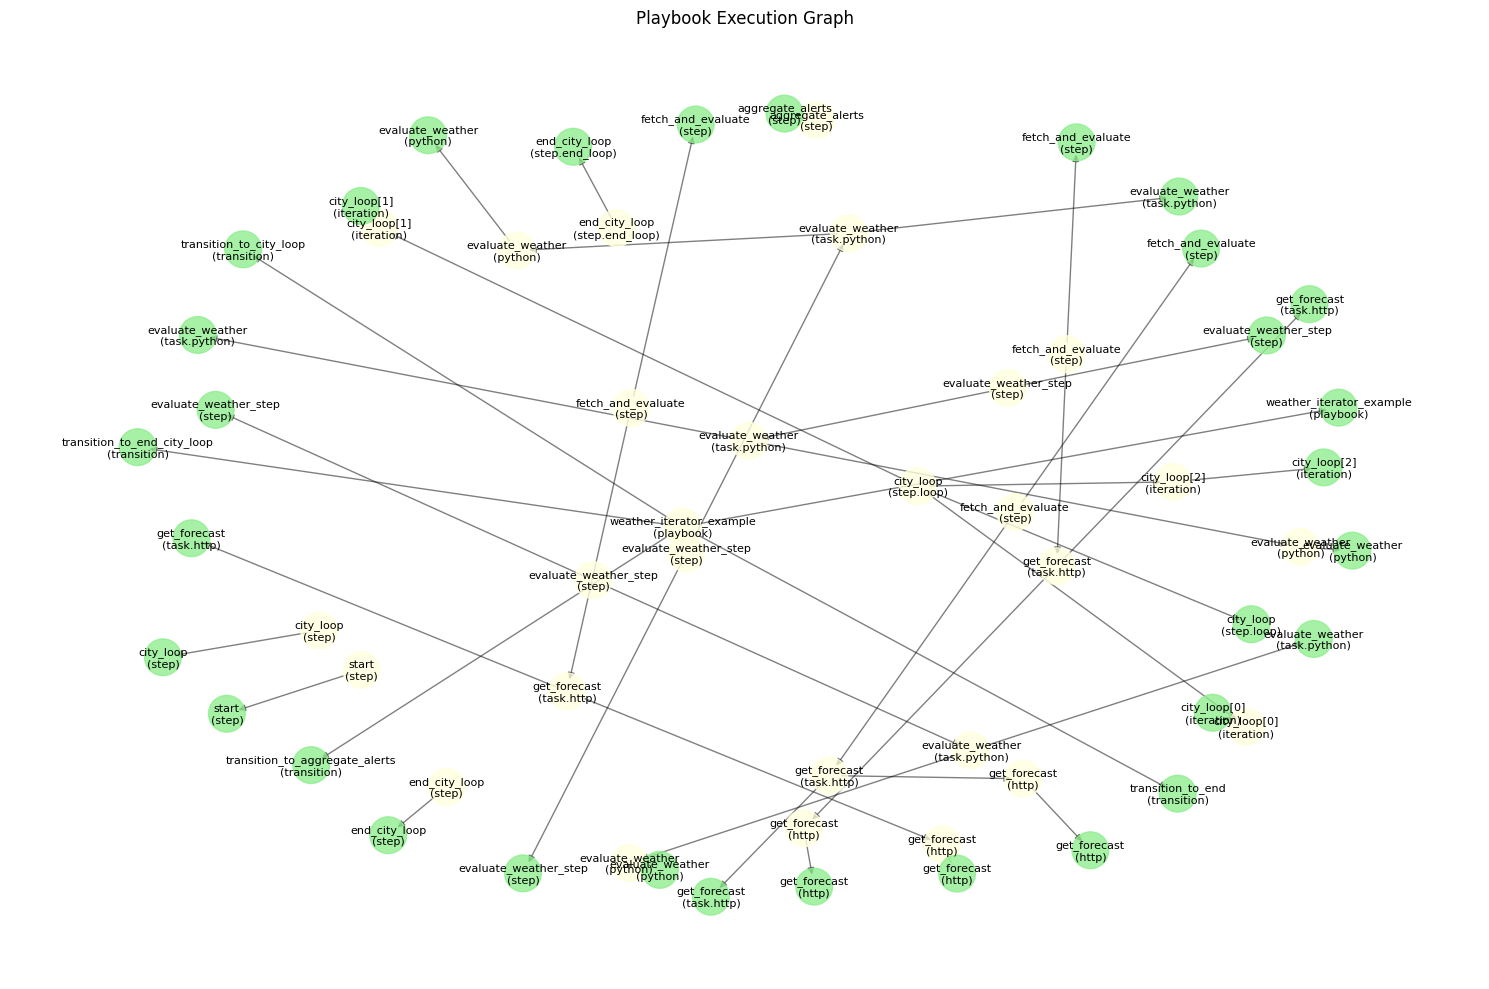

In [148]:
if execution_id:
    graph_data = con.execute("""
        SELECT 
            event_id, 
            parent_event_id, 
            node_id, 
            node_name, 
            node_type, 
            event_type, 
            status
        FROM event_log
        WHERE execution_id = ?
        ORDER BY timestamp
    """, [execution_id]).fetchall()

    G = nx.DiGraph()
    node_colors = []
    node_labels = {}

    for event in graph_data:
        event_id, parent_event_id, node_id, node_name, node_type, event_type, status = event

        if not G.has_node(event_id):
            G.add_node(event_id)
            node_labels[event_id] = f"{node_name}\n({node_type})"

            if status == 'success':
                node_colors.append('lightgreen')
            elif status == 'error':
                node_colors.append('lightcoral')
            elif status == 'in_progress':
                node_colors.append('lightyellow')
            else:
                node_colors.append('lightblue')

        if parent_event_id and G.has_node(parent_event_id):
            G.add_edge(parent_event_id, event_id)
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, arrows=True)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    plt.title("Playbook Execution Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No execution ID available for graph visualization.")


## Workflow Block Schema Visualization

The execution flow as a block schema, highlighting sequential steps and forks in the workflow.


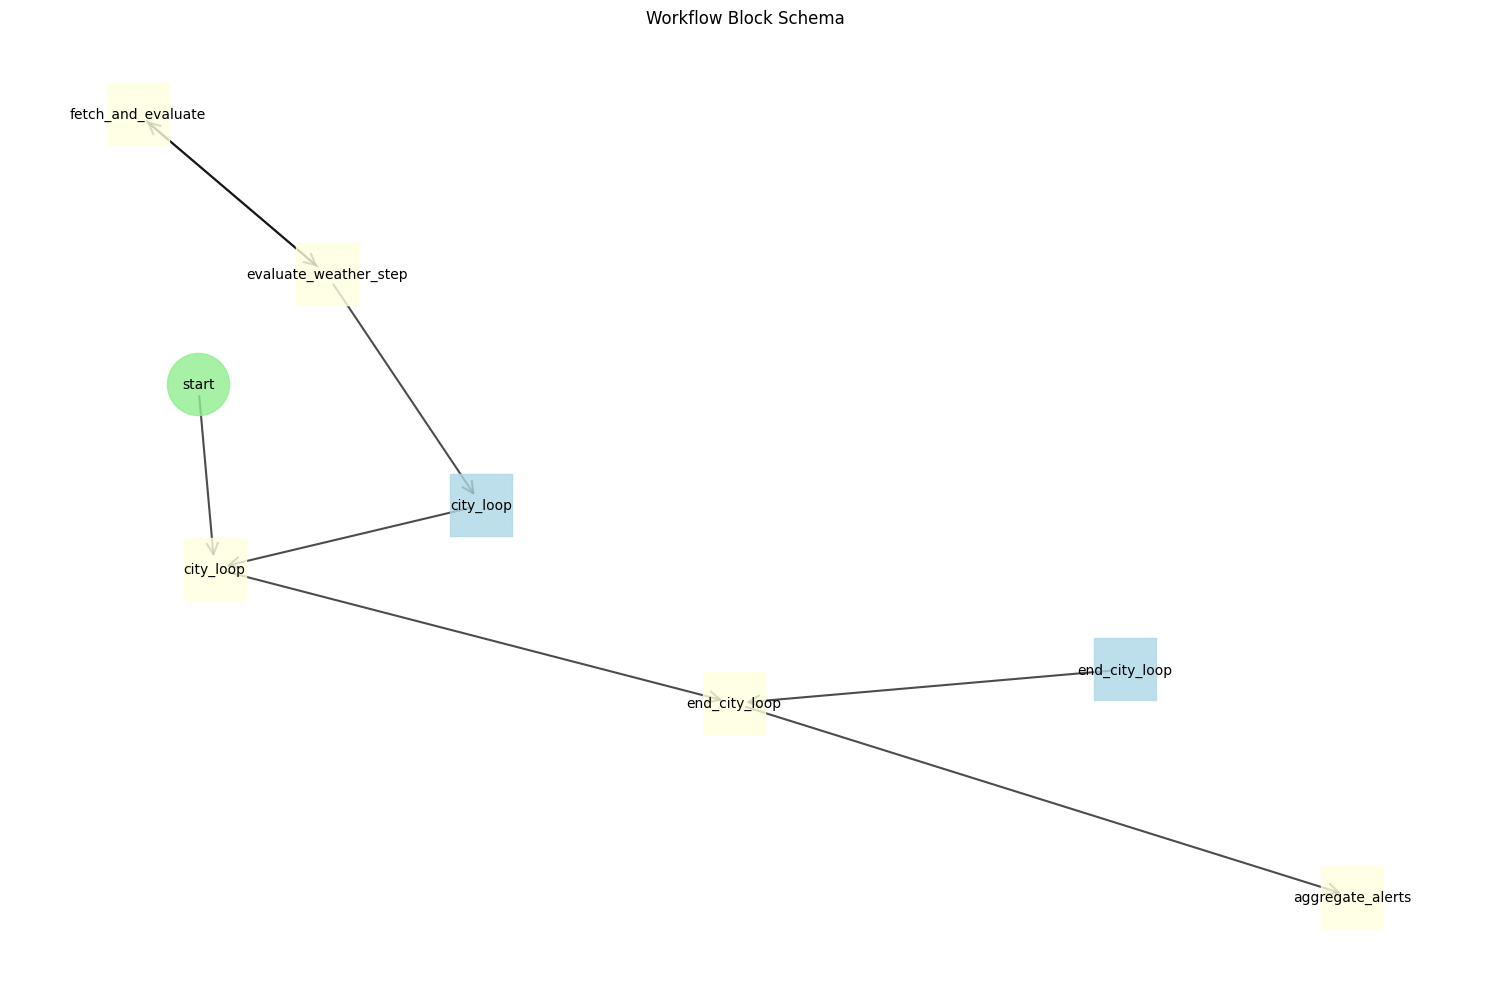

Workflow contains 8 unique steps and 8 transitions
Sequential steps: 6
Fork points: 1
Fork points (steps with multiple outgoing transitions):
  - evaluate_weather_step (2 branches)


In [149]:
if execution_id:
    workflow_data = con.execute("""
        SELECT 
            event_id, 
            parent_event_id, 
            node_id, 
            node_name, 
            node_type, 
            event_type, 
            status,
            metadata
        FROM event_log
        WHERE execution_id = ? AND node_type IN ('step', 'step.loop', 'step.end_loop')
        ORDER BY timestamp
    """, [execution_id]).fetchall()

    WG = nx.DiGraph()
    node_by_name = {}
    for event in workflow_data:
        event_id, parent_event_id, node_id, node_name, node_type, event_type, status, metadata = event
        if 'error' in event_type or event_type in ['execution_start', 'execution_complete']:
            continue
        node_key = f"{node_name}_{node_type}"
        if node_key not in node_by_name:
            node_by_name[node_key] = node_key

            if 'loop' in node_type:
                node_shape = 'box'
                node_color = 'lightblue'
            elif node_name in ['start', 'end']:
                node_shape = 'oval'
                node_color = 'lightgreen' if node_name == 'start' else 'lightcoral'
            else:
                node_shape = 'box'
                node_color = 'lightyellow'
            WG.add_node(node_key, label=node_name, shape=node_shape, color=node_color, type=node_type)

    step_transitions = {}

    for i in range(len(workflow_data) - 1):
        current = workflow_data[i]
        next_event = workflow_data[i + 1]

        current_name = current[3]  # node_name
        current_type = current[4]  # node_type
        current_event_type = current[5]  # event_type

        next_name = next_event[3]  # node_name
        next_type = next_event[4]  # node_type

        if 'start' in current_event_type or 'error' in current_event_type:
            continue

        current_key = f"{current_name}_{current_type}"
        next_key = f"{next_name}_{next_type}"

        if current_key in node_by_name and next_key in node_by_name:
            transition_key = f"{current_key}_{next_key}"
            if transition_key not in step_transitions:
                step_transitions[transition_key] = True
                WG.add_edge(current_key, next_key)

    plt.figure(figsize=(15, 10))

    try:
        import pygraphviz
        pos = nx.nx_agraph.graphviz_layout(WG, prog='dot', args='-Grankdir=TB')
    except (ImportError, AttributeError):
        try:
            import pydot
            pos = nx.drawing.nx_pydot.pydot_layout(WG, prog='dot')
        except (ImportError, AttributeError):
            pos = nx.spring_layout(WG, seed=42)

    for node, attrs in WG.nodes(data=True):
        shape = attrs.get('shape', 'box')
        color = attrs.get('color', 'lightgray')
        label = attrs.get('label', node)

        if shape == 'box':
            nx.draw_networkx_nodes(WG, pos, nodelist=[node], node_color=color, node_shape='s', node_size=2000, alpha=0.8)
        elif shape == 'oval':
            nx.draw_networkx_nodes(WG, pos, nodelist=[node], node_color=color, node_shape='o', node_size=2000, alpha=0.8)

        x, y = pos[node]
        plt.text(x, y, label, fontsize=10, ha='center', va='center')

    nx.draw_networkx_edges(WG, pos, width=1.5, alpha=0.7, arrowsize=20, arrowstyle='->')

    plt.title("Workflow Block Schema")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Workflow contains {WG.number_of_nodes()} unique steps and {WG.number_of_edges()} transitions")

    sequential_nodes = []
    fork_nodes = []

    for node in WG.nodes():
        out_degree = WG.out_degree(node)
        if out_degree > 1:
            fork_nodes.append(node)
        elif out_degree == 1:
            sequential_nodes.append(node)

    print(f"Sequential steps: {len(sequential_nodes)}")
    print(f"Fork points: {len(fork_nodes)}")
    if fork_nodes:
        print("Fork points (steps with multiple outgoing transitions):")
        for node in fork_nodes:
            print(f"  - {WG.nodes[node]['label']} ({WG.out_degree(node)} branches)")
else:
    print("No execution ID for workflow visualization.")


## Preview `event_log` table


In [131]:
table_name = 'event_log'
event_log_df = pl.from_arrow(con.execute(f"SELECT * FROM {table_name} LIMIT 100").arrow())
event_log_df


execution_id,event_id,parent_event_id,timestamp,event_type,node_id,node_name,node_type,status,duration,input_context,output_result,metadata
str,str,str,datetime[μs],str,str,str,str,str,f64,str,str,str
"""b20125a1-1eed-4015-a4ee-e6ea55…","""fbed0b56-594c-45a1-8b8b-26da22…",null,2025-06-16 06:30:01.914083,"""execution_start""","""b20125a1-1eed-4015-a4ee-e6ea55…","""weather_iterator_example""","""playbook""","""in_progress""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""playbook_path"": ""./catalog/p…"
"""b20125a1-1eed-4015-a4ee-e6ea55…","""e3e40764-e91d-40d6-afd5-74c088…",null,2025-06-16 06:30:01.915067,"""step_start""","""9d185ce7-f540-47ff-b779-07797b…","""start""","""step""","""in_progress""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""step_type"": ""standard""}"""
"""b20125a1-1eed-4015-a4ee-e6ea55…","""34c1dc5a-985a-4d0a-9784-474434…","""e3e40764-e91d-40d6-afd5-74c088…",2025-06-16 06:30:01.915896,"""step_complete""","""9d185ce7-f540-47ff-b779-07797b…","""start""","""step""","""success""",0.000897,"""{""jobId"": ""{{ job.uuid }}"", ""s…","""{}""","""{""step_type"": ""standard""}"""
"""b20125a1-1eed-4015-a4ee-e6ea55…","""785d1244-82eb-4572-a7bf-06f40d…","""fbed0b56-594c-45a1-8b8b-26da22…",2025-06-16 06:30:01.918316,"""step_transition""","""b20125a1-1eed-4015-a4ee-e6ea55…","""transition_to_city_loop""","""transition""","""success""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""from_step"": ""start"", ""to_ste…"
"""b20125a1-1eed-4015-a4ee-e6ea55…","""2aa80574-ffa8-43f9-8ba2-15081a…",null,2025-06-16 06:30:01.919014,"""step_start""","""7cdac2c8-c330-4914-9721-ab2ad5…","""city_loop""","""step""","""in_progress""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""step_type"": ""standard""}"""
…,…,…,…,…,…,…,…,…,…,…,…,…
"""b20125a1-1eed-4015-a4ee-e6ea55…","""48c92fe7-1cf3-4b02-b371-a7f672…","""fbed0b56-594c-45a1-8b8b-26da22…",2025-06-16 06:30:04.173560,"""step_transition""","""b20125a1-1eed-4015-a4ee-e6ea55…","""transition_to_aggregate_alerts""","""transition""","""success""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""from_step"": ""end_city_loop"",…"
"""b20125a1-1eed-4015-a4ee-e6ea55…","""1f772336-41e4-432a-b27f-ca816a…",null,2025-06-16 06:30:04.175179,"""step_start""","""289243e5-8e42-4eb6-ac2a-a7c726…","""aggregate_alerts""","""step""","""in_progress""",0.0,"""{""jobId"": ""{{ job.uuid }}"", ""s…",null,"""{""step_type"": ""standard""}"""
"""b20125a1-1eed-4015-a4ee-e6ea55…","""a95ffa1b-421b-46d5-b227-fb7b60…","""1f772336-41e4-432a-b27f-ca816a…",2025-06-16 06:30:04.176362,"""step_complete""","""289243e5-8e42-4eb6-ac2a-a7c726…","""aggregate_alerts""","""step""","""success""",0.002061,"""{""jobId"": ""{{ job.uuid }}"", ""s…","""{}""","""{""step_type"": ""standard""}"""


## Step Results

The step results from the playbook execution.


In [132]:
step_results_df = pl.from_arrow(con.execute("SELECT * FROM step_result ORDER BY timestamp DESC LIMIT 10").arrow())
step_results_df = parse_json_column(step_results_df, 'data')
step_results_df


shape: (4, 8)
┌─────────────┬─────────────┬─────────────┬────────────┬────────────┬─────────┬────────────┬───────┐
│ execution_i ┆ step_id     ┆ step_name   ┆ parent_id  ┆ timestamp  ┆ status  ┆ data       ┆ error │
│ d           ┆ ---         ┆ ---         ┆ ---        ┆ ---        ┆ ---     ┆ ---        ┆ ---   │
│ ---         ┆ str         ┆ str         ┆ str        ┆ datetime[μ ┆ str     ┆ object     ┆ str   │
│ str         ┆             ┆             ┆            ┆ s]         ┆         ┆            ┆       │
╞═════════════╪═════════════╪═════════════╪════════════╪════════════╪═════════╪════════════╪═══════╡
│ b20125a1-1e ┆ 289243e5-8e ┆ aggregate_a ┆ null       ┆ 2025-06-16 ┆ success ┆ {}         ┆ null  │
│ ed-4015-a4e ┆ 42-4eb6-ac2 ┆ lerts       ┆            ┆ 06:30:04.1 ┆         ┆            ┆       │
│ e-e6ea55…   ┆ a-a7c726…   ┆             ┆            ┆ 75655      ┆         ┆            ┆       │
│ b20125a1-1e ┆ ddb4f7b3-ce ┆ end_city_lo ┆ 518ace9b-b ┆ 2025-06-16 ┆ success ┆ {'alerts': ┆ null  │
│ ed-4015-a4e ┆ 6e-4301-956 ┆ op          ┆ f76-4d89-b ┆ 06:30:04.1 ┆         ┆ [{'fetch_a ┆       │
│ e-e6ea55…   ┆ 9-88f060…   ┆             ┆ 915-ab93d5 ┆ 71439      ┆         ┆ nd_evalua… ┆       │
│             ┆             ┆             ┆ …          ┆            ┆         ┆            ┆       │
│ b20125a1-1e ┆ 7cdac2c8-c3 ┆ city_loop   ┆ null       ┆ 2025-06-16 ┆ success ┆ [{'fetch_a ┆ null  │
│ ed-4015-a4e ┆ 30-4914-972 ┆             ┆            ┆ 06:30:04.1 ┆         ┆ nd_evaluat ┆       │
│ e-e6ea55…   ┆ 1-ab2ad5…   ┆             ┆            ┆ 55156      ┆         ┆ e':        ┆       │
│             ┆             ┆             ┆            ┆            ┆         ┆ {'data…    ┆       │
│ b20125a1-1e ┆ 9d185ce7-f5 ┆ start       ┆ null       ┆ 2025-06-16 ┆ success ┆ {}         ┆ null  │
│ ed-4015-a4e ┆ 40-47ff-b77 ┆             ┆            ┆ 06:30:01.9 ┆         ┆            ┆       │
│ e-e6ea55…   ┆ 9-07797b…   ┆             ┆            ┆ 15530      ┆         ┆            ┆       │
└─────────────┴─────────────┴─────────────┴────────────┴────────────┴─────────┴────────────┴───────┘

## Task Results

The recent task results from the playbook execution.


In [152]:
task_results_df = pl.from_arrow(con.execute("SELECT * FROM task_result ORDER BY timestamp DESC LIMIT 10").arrow())
task_results_df = parse_json_column(task_results_df, 'data')
task_results_df


execution_id,task_id,task_name,task_type,parent_id,timestamp,status,data,error
str,str,str,str,str,datetime[μs],str,object,str
"""b20125a1-1eed-4015-a4ee-e6ea55…","""d8bcf1fc-e512-4cc7-bfed-d53eb3…","""evaluate_weather""","""python""","""729ec95b-551c-41e7-8e41-393164…",2025-06-16 06:30:04.149062,"""success""","{'city': 'Berlin', 'max_temp': 23.1, 'alert': False}",null
"""b20125a1-1eed-4015-a4ee-e6ea55…","""96ac962f-9d1d-401d-a44c-5d4be4…","""get_forecast""","""http""","""d127ce2b-e62b-4753-9b85-bf5558…",2025-06-16 06:30:04.130915,"""success""","{'data': {'latitude': 52.52, 'longitude': 13.419998, 'generationtime_ms': 0.021576881408691406, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 38.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-06-16T02:00', '2025-06-16T03:00', '2025-06-16T04:00', '2025-06-16T05:00', '2025-06-16T06:00', '2025-06-16T07:00', '2025-06-16T08:00', '2025-06-16T09:00', '2025-06-16T10:00', '2025-06-16T11:00', '2025-06-16T12:00', '2025-06-16T13:00', '2025-06-16T14:00', '2025-06-16T15:00', '2025-06-16T16:00', '2025-06-16T17:00', '2025-06-16T18:00', '2025-06-16T19:00', '2025-06-16T20:00', '2025-06-16T21:00', '2025-06-16T22:00', '2025-06-16T23:00'], 'temperature_2m': [16.9, 16.9, 16.8, 16.9, 16.7, 16.5, 15.6, 17.2, 18.6, 17.7, 18.0, 19.7, 20.8, 22.3, 22.3, 22.8, 23.1, 22.2, 21.5, 20.5, 19.3, 18.4, 17.6, 16.8]}}, 'status_code': 200, 'headers': {'date': 'Mon, 16 Jun 2025 13:30:04 GMT', 'content-type': 'application/json; charset=utf-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'content-encoding': 'deflate'}}",null
"""b20125a1-1eed-4015-a4ee-e6ea55…","""6b0cb0cf-df1d-439c-b0b8-b00cee…","""evaluate_weather""","""python""","""d21a8b35-8a31-4bae-a5e8-a71cbe…",2025-06-16 06:30:03.440008,"""success""","{'city': 'Paris', 'max_temp': 26.5, 'alert': True}",null
"""b20125a1-1eed-4015-a4ee-e6ea55…","""21cc73f0-fecc-4694-a7d9-dff2d0…","""get_forecast""","""http""","""ccb48992-b532-457b-8851-d787c4…",2025-06-16 06:30:03.425831,"""success""","{'data': {'latitude': 48.84, 'longitude': 2.3599997, 'generationtime_ms': 0.02944469451904297, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 46.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-06-16T02:00', '2025-06-16T03:00', '2025-06-16T04:00', '2025-06-16T05:00', '2025-06-16T06:00', '2025-06-16T07:00', '2025-06-16T08:00', '2025-06-16T09:00', '2025-06-16T10:00', '2025-06-16T11:00', '2025-06-16T12:00', '2025-06-16T13:00', '2025-06-16T14:00', '2025-06-16T15:00', '2025-06-16T16:00', '2025-06-16T17:00', '2025-06-16T18:00', '2025-06-16T19:00', '2025-06-16T20:00', '2025-06-16T21:00', '2025-06-16T22:00', '2025-06-16T23:00'], 'temperature_2m': [16.3, 15.7, 15.2, 14.5, 14.1, 14.1, 14.8, 15.7, 17.1, 19.4, 21.0, 22.4, 23.8, 25.1, 25.8, 26.0, 26.5, 26.0, 25.6, 25.0, 24.5, 23.5, 22.5, 21.3]}}, 'status_code': 200, 'headers': {'date': 'Mon, 16 Jun 2025 13:30:03 GMT', 'content-type': 'application/json; charset=utf-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'content-encoding': 'deflate'}}",null
"""b20125a1-1eed-4015-a4ee-e6ea55…","""b9a82f30-87e3-470c-9e51-73686d…","""evaluate_weather""","""python""","""89f93495-066c-405c-8e4c-c00f80…",2025-06-16 06:30:02.746455,"""success""","{'city': 'London', 'max_temp': 25.3, 'alert': True}",null
"""b20125a1-1eed-4015-a4ee-e6ea55…","""7d4f7d81-8901-4f6b-a221-e5f794…","""get_forecast""","""http""","""9a0a3928-3095-40d0-80cd-2ca6bc…",2025-06-16 06:30:02.729848,"""success""","{'data': {'latitude': 51.5, 'longitude': -0.120000124, 'generationtime_ms': 0.06711483001708984, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 29.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C'}, 'hourly': {'time': ['2025-06-16T00:00', '2025-06-16T01:00', '2025-0

## Postgres Results

Results stored in the Postgres database.


Weather Alert Summary from Postgres:


,id,alert_cities,alert_count,created_at
0,1750233964397,"[""London"", ""Paris"", ""Berlin""]",3,2025-06-18 03:06:04.421654


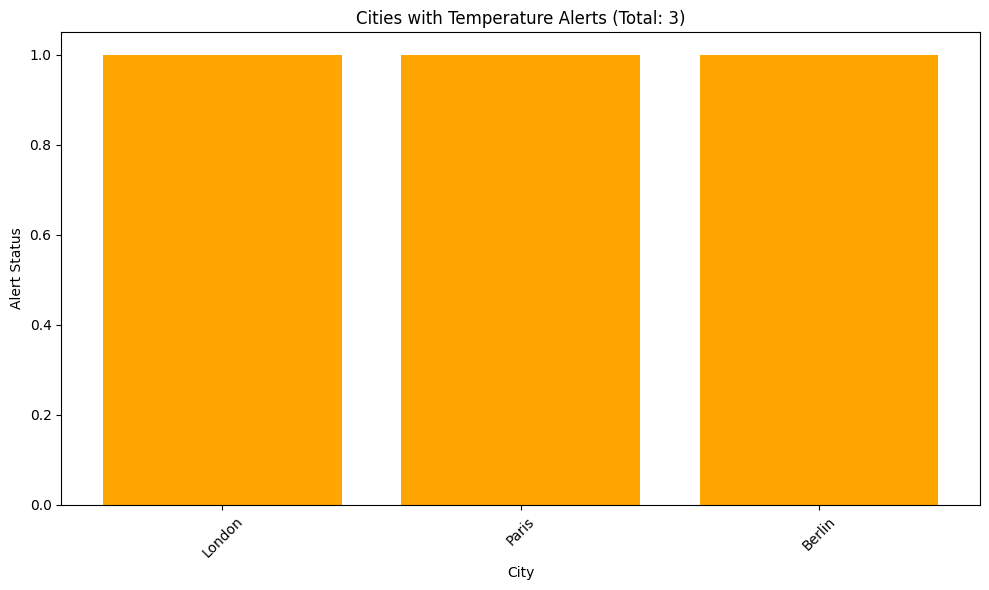

In [134]:
try:
    con.execute("INSTALL postgres;")
    con.execute("LOAD postgres;")
    attached_dbs = con.execute("SHOW DATABASES").fetchall()
    postgres_db_attached = any(db[0] == 'postgres_db' for db in attached_dbs)
    if not postgres_db_attached:
        con.execute("ATTACH 'dbname=noetl user=noetl password=noetl host=localhost port=5434' AS postgres_db (TYPE postgres);")
    postgres_results = con.execute("""
        SELECT * FROM postgres_db.weather_alert_summary
        ORDER BY created_at DESC
        LIMIT 10
    """).fetchdf()

    print("Weather Alert Summary from Postgres:")
    display(postgres_results)

    if not postgres_results.empty:
        plt.figure(figsize=(10, 6))

        def parse_cities(cities_json):
            try:
                return json.loads(cities_json)
            except:
                return []

        latest_record = postgres_results.iloc[0]
        cities = parse_cities(latest_record['alert_cities'])

        if cities:
            plt.bar(cities, [1] * len(cities), color='orange')
            plt.title(f"Cities with Temperature Alerts (Total: {latest_record['alert_count']})")
            plt.xlabel("City")
            plt.ylabel("Alert Status")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("No cities with alerts found in the latest record.")
    else:
        print("No data found in the weather_alert_summary table.")

except Exception as e:
    print(f"Error connecting to Postgres: {e}")
    print("Make sure the Postgres database is running and accessible.")


## SQL Query Interface

SQL interface for querying the DuckDB database.


In [138]:
%reload_ext sql
%sql con --alias duckdb
%sql SELECT * FROM task_result ORDER BY timestamp DESC LIMIT 1


The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

Running query in 'duckdb'

execution_id,task_id,task_name,task_type,parent_id,timestamp,status,data,error
b20125a1-1eed-4015-a4ee-e6ea556c1f4b,d8bcf1fc-e512-4cc7-bfed-d53eb3c18a33,evaluate_weather,python,729ec95b-551c-41e7-8e41-393164fdd305,2025-06-16 06:30:04.149062,success,"{""city"": ""Berlin"", ""max_temp"": 23.1, ""alert"": false}",None


In [139]:
%sql SELECT * FROM event_log LIMIT 1


Running query in 'duckdb'

execution_id,event_id,parent_event_id,timestamp,event_type,node_id,node_name,node_type,status,duration,input_context,output_result,metadata
b20125a1-1eed-4015-a4ee-e6ea556c1f4b,fbed0b56-594c-45a1-8b8b-26da22fb3436,None,2025-06-16 06:30:01.914083,execution_start,b20125a1-1eed-4015-a4ee-e6ea556c1f4b,weather_iterator_example,playbook,in_progress,0.0,"{""jobId"": ""{{ job.uuid }}"", ""state"": ""ready"", ""cities"": [{""name"": ""London"", ""lat"": 51.51, ""lon"": -0.13}, {""name"": ""Paris"", ""lat"": 48.85, ""lon"": 2.35}, {""name"": ""Berlin"", ""lat"": 52.52, ""lon"": 13.41}], ""base_url"": ""https://api.open-meteo.com/v1"", ""temperature_threshold"": 25, ""workload"": {""jobId"": ""{{ job.uuid }}"", ""state"": ""ready"", ""cities"": [{""name"": ""London"", ""lat"": 51.51, ""lon"": -0.13}, {""name"": ""Paris"", ""lat"": 48.85, ""lon"": 2.35}, {""name"": ""Berlin"", ""lat"": 52.52, ""lon"": 13.41}], ""base_url"": ""https://api.open-meteo.com/v1"", ""temperature_threshold"": 25}, ""execution_start"": ""2025-06-16T06:30:01.913746""}",None,"{""playbook_path"": ""./catalog/playbooks/weather_example.yaml""}"


## Execution Summary

Summary of the playbook execution, including key metrics and findings.


## Playbook Execution Summary
Total Steps: 4
Successful Steps: 4
Step Success Rate: 100.00%

Total Tasks: 6
Successful Tasks: 6
Task Success Rate: 100.00%



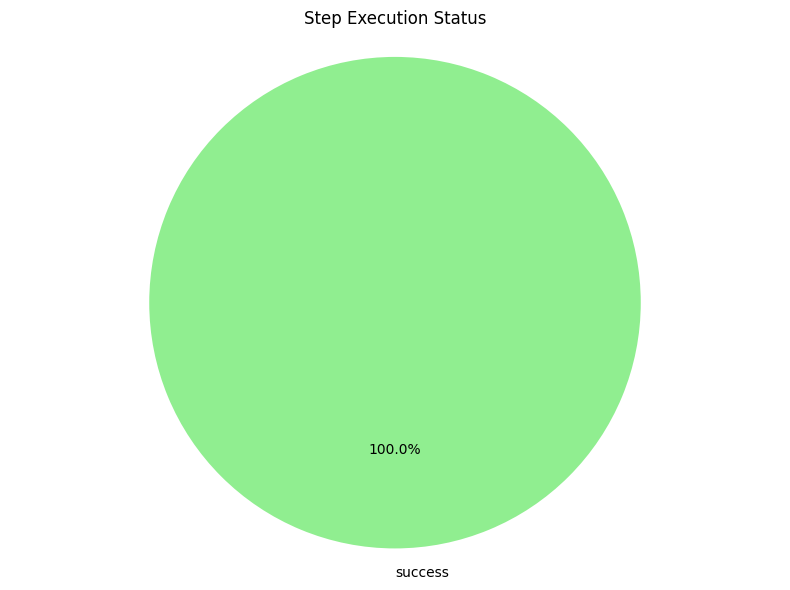

In [151]:
if execution_id:
    summary_data = {}

    step_stats = con.execute("""
        SELECT 
            COUNT(*) as total_steps,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as successful_steps,
            CAST(COUNT(CASE WHEN status = 'success' THEN 1 END) AS FLOAT) / COUNT(*) * 100 as success_rate
        FROM step_result
        WHERE execution_id = ?
    """, [execution_id]).fetchone()

    summary_data['step_stats'] = {
        'total': step_stats[0],
        'successful': step_stats[1],
        'success_rate': step_stats[2]
    }

    task_stats = con.execute("""
        SELECT 
            COUNT(*) as total_tasks,
            COUNT(CASE WHEN status = 'success' THEN 1 END) as successful_tasks,
            CAST(COUNT(CASE WHEN status = 'success' THEN 1 END) AS FLOAT) / COUNT(*) * 100 as success_rate
        FROM task_result
        WHERE execution_id = ?
    """, [execution_id]).fetchone()

    summary_data['task_stats'] = {
        'total': task_stats[0],
        'successful': task_stats[1],
        'success_rate': task_stats[2]
    }

    try:
        weather_summary = con.execute("""
            SELECT data
            FROM task_result
            WHERE execution_id = ? AND task_name = 'aggregate_alerts_task'
            ORDER BY timestamp DESC
            LIMIT 1
        """, [execution_id]).fetchone()

        if weather_summary and weather_summary[0]:
            summary_data['weather_summary'] = json.loads(weather_summary[0])
    except:
        pass

    print("## Playbook Execution Summary")
    print(f"Total Steps: {summary_data['step_stats']['total']}")
    print(f"Successful Steps: {summary_data['step_stats']['successful']}")
    print(f"Step Success Rate: {summary_data['step_stats']['success_rate']:.2f}%")
    print()
    print(f"Total Tasks: {summary_data['task_stats']['total']}")
    print(f"Successful Tasks: {summary_data['task_stats']['successful']}")
    print(f"Task Success Rate: {summary_data['task_stats']['success_rate']:.2f}%")
    print()

    if 'weather_summary' in summary_data:
        print("## Weather Alert Summary")
        if 'summary' in summary_data['weather_summary']:
            summary = summary_data['weather_summary']['summary']
            print(f"Alert Cities: {', '.join(summary.get('alert_cities', []))}")
            print(f"Alert Count: {summary.get('count', 0)}")
        else:
            print("No weather alert summary found.")

    step_status_counts = con.execute("""
        SELECT 
            status,
            COUNT(*) as count
        FROM step_result
        WHERE execution_id = ?
        GROUP BY status
    """, [execution_id]).fetchall()

    if step_status_counts:
        plt.figure(figsize=(8, 6))
        labels = [status[0] for status in step_status_counts]
        sizes = [status[1] for status in step_status_counts]
        colors = ['lightgreen' if label == 'success' else 'lightcoral' if label == 'error' else 'lightyellow' for label in labels]

        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.axis('equal')
        plt.title('Step Execution Status')
        plt.tight_layout()
        plt.show()
else:
    print("No execution ID for summary.")
